### Import libraries

In [16]:
import cv2
import numpy as np
import pandas as pd
# from absl import flags
import tensorflow as tf
import tensorflow_privacy
from keras.models import Model
import matplotlib.pyplot as plt
from skimage.feature import hog
from PIL import Image, ImageOps
import tensorflow_addons as tfa
from keras.models import Sequential
# from livelossplot import PlotLossesKeras
from keras.applications.vgg16 import VGG16
from keras.layers.convolutional import Conv2D
from tensorflow.keras.datasets import cifar10
from tensorflow_privacy import DPKerasSGDOptimizer, DPKerasAdamOptimizer, DPKerasAdagradOptimizer
from tensorflow_addons.layers import GroupNormalization
from keras.layers import Input, Dense, Flatten, Dropout, Add, LayerNormalization
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from keras.layers.pooling import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
tf.compat.v1.disable_v2_behavior()
tf.get_logger().setLevel('ERROR')
%matplotlib inline

### Load Dataset

In [17]:
def hog_transform(train):
    train_hog = []
    for sample in train:
        img = Image.fromarray(np.uint8(sample)).convert('RGB')
        img = ImageOps.grayscale(img)
        hog_features = hog(img, orientations = 9, pixels_per_cell = (8, 8), 
                           cells_per_block = (4, 4), block_norm = 'L2', visualize = False)
        train_hog.append(hog_features)
    train_hog = np.array(train_hog)
    return train_hog

In [18]:
# Loading cifar10 image dataset
data_train, data_test = cifar10.load_data()
x_train, y_train = data_train
x_test, y_test = data_test

# # Hog transformations of images
# x_train_hog = hog_transform(x_train)
# x_test_hog = hog_transform(x_test)

# Normalizing pixel values of images
x_train = x_train / 255.0
x_test = x_test / 255.0

# Flattening images in dataset
y_train = y_train.flatten().reshape(y_train.shape[0], 1)
y_test = y_test.flatten().reshape(y_test.shape[0], 1)

# One hot encoding of labels/target column
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print("training:", x_train.shape, y_train.shape)
print("testing:", x_test.shape, y_test.shape)
print("--------------------------------")
# print("hog training:", x_train_hog.shape, y_train.shape)
# print("hog testing:", x_test_hog.shape, y_test.shape)

training: (50000, 32, 32, 3) (50000, 10)
testing: (10000, 32, 32, 3) (10000, 10)
--------------------------------


### Model Architectures

In [11]:
#### Simple CNN
def m1_cnn():
    model_input = Input(shape = (32, 32, 3))
    x1 = Conv2D(16, (3, 3), activation = 'tanh', strides = 2)(model_input)
    ftn = Flatten()(x1)
    # Feed-forward network
    model_output = Dense(10)(ftn)
    model = Model(inputs = model_input, outputs = model_output)
    return model


#### VGG with transfer learning
def pre_trained_vgg():
    #Building a VGG model with pretrained weights from cifar100
    model = Sequential()
    vgg_model = VGG16(include_top=False, weights="imagenet",
                      classes=10, pooling=max, input_shape=(32,32,3))
    vgg_model.trainable=False
    model.add(vgg_model)
    model.add(Flatten())
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(16, activation='tanh'))
    model.add(Dense(10, activation='softmax'))
    return model


#### HOG + ANN
def hog_ann():
    ### Feed-forward network
    model_input = Input(shape = (144))
    d = Dense(16, activation = 'tanh')(model_input)
    d = LayerNormalization()(d)
    d = Dropout(0.1)(d)
    d = Dense(16, activation = 'tanh')(d)
    d = LayerNormalization()(d)
    d = Dense(16, activation = 'tanh')(d)
    d = Dropout(0.1)(d)
    d = Dense(8, activation = 'tanh')(d)
    d = LayerNormalization()(d)
#     d = Dense(8, activation = 'tanh')(d)
    model_output = Dense(10, activation = 'softmax')(d)
    model = Model(inputs = model_input, outputs = model_output)
    return model


#### Custom CNN
def cnn():
    ## CNN network
    model_input = Input(shape = (32, 32, 3))
    x1 = Conv2D(16, (8, 8), activation = 'tanh', strides = 2)(model_input)
    x1 = LayerNormalization()(x1)
    x1 = Dropout(0.4)(x1)
    x1 = MaxPooling2D(pool_size = (2,1))(x1)
    x2 = Conv2D(32, (4, 4), activation = 'tanh', strides = 2)(x1)
    x2 = MaxPooling2D(pool_size = (2,1))(x2)
    x2 = LayerNormalization()(x2)
    ftn = Flatten()(x2)
    ### Feed-forward network
    d1 = Dense(8, activation = 'tanh')(ftn)
    d1 = Dropout(0.1)(d1)
    d2 = Dense(16, activation = 'tanh')(d1)
    d2 = LayerNormalization()(d2)
    d3 = Dropout(0.1)(d2)
    d4 = Dense(8, activation = 'tanh')(d3)
    d4 = LayerNormalization()(d4)
    d5 = Dense(8, activation = 'tanh')(d4)
    model_output = Dense(10, activation = 'softmax')(d5)
    model = Model(inputs = model_input, outputs = model_output)
    return model


#### ResNet-10
def resnet():
    ### Custom ResNet model
    model_input = Input(shape = (32, 32, 3))
    x1 = Conv2D(8, (3, 3), activation = 'tanh', strides = 2)(model_input)
#     x2 = Conv2D(32, (3, 3), activation = 'tanh', strides = 2)(x1)
    x2 = MaxPooling2D(pool_size = (3,3))(x1)
    ## Residual Block 1
    x3 = Conv2D(8, (3, 3), activation = 'relu', strides = 1)(x2)
    x3 = LayerNormalization()(x3) # normalization layer 1
    x4 = Conv2D(8, (3, 3), activation = 'relu', strides = 1)(x3)
    sk1 = Add()([x2, x4]) # skip connection 1
    ## Residual Block 2
    x5 = Conv2D(8, (3, 3), activation = 'relu', strides = 1)(sk1)
    x5 = LayerNormalization()(x5) # normalization layer 2
    x6 = Conv2D(8, (3, 3), activation = 'relu', strides = 1)(x5)
    sk2 = Add()([sk1, x6]) # skip connection 2
#     ## Residual Block 3
#     x7 = Conv2D(64, (3, 3), activation = 'relu', strides = 1)(sk2)
#     x7 = LayerNormalization()(x7) # normalization layer 3
#     x8 = Conv2D(64, (3, 3), activation = 'relu', strides = 1)(x7)
#     sk3 = Add()([sk2, x8]) # skip connection 3
#     ## Residual Block 4
#     x9 = Conv2D(64, (3, 3), activation = 'relu', strides = 1)(sk3)
#     x9 = LayerNormalization()(x9) # normalization layer 4
#     x10 = Conv2D(64, (3, 3), activation = 'relu', strides = 1)(x9)
#     sk4 = Add()([sk3, x10]) # skip connection 4
    ## Global Average Pooling layer
    avg = GlobalAveragePooling2D()(sk2)
    ftn = Flatten()(avg)
    # Feed-forward network
    d1 = Dense(16, activation = 'tanh')(ftn)
    d2 = Dense(16, activation = 'tanh')(d1)
    model_output = Dense(10, activation = 'softmax')(d2)
    model = Model(inputs = model_input, outputs = model_output)
    return model


#### VGG-8
def vgg():
    ### Custom VGG model
    model_input = Input(shape = (32, 32, 3))
    x1 = Conv2D(8, (3, 3), activation = 'tanh', strides = 1)(model_input)
#     x2 = Conv2D(64, (3, 3), activation = 'tanh', strides = 1)(x1)
    x2 = MaxPooling2D(pool_size = (3,3), strides = 2)(x1)
    x3 = Conv2D(16, (3, 3), activation = 'tanh', strides = 1)(x2)
    x4 = Conv2D(32, (3, 3), activation = 'tanh', strides = 1)(x3)
    x4 = MaxPooling2D(pool_size = (3,3), strides = 2)(x4)
#     x5 = Conv2D(32, (3, 3), activation = 'tanh', strides = 1)(x4)
#     x6 = Conv2D(32, (3, 3), activation = 'relu', strides = 1)(x5)
#     x7 = Conv2D(32, (3, 3), activation = 'relu', strides = 1)(x6)
    x7 = MaxPooling2D(pool_size = (3,3), strides = 2)(x4)
    ftn = Flatten()(x7)
    # Feed-forward network
    d1 = Dense(8, activation = 'tanh')(ftn)
    d1 = Dropout(0.4)(d1)
    d2 = Dense(16, activation = 'tanh')(d1)
    d2 = Dropout(0.4)(d2)
    model_output = Dense(10, activation = 'softmax')(d2)
    model = Model(inputs = model_input, outputs = model_output)
    return model

### Privacy Hyper-parameters

In [12]:
epochs = 100 
batch_size = 100 
l2_norm_clip = 1 
noise_multiplier = 1.25 
num_microbatches = batch_size
learning_rate = 0.25   
delta = 1e-5

if batch_size % num_microbatches != 0:
    raise ValueError('Batch size should be an integer multiple of the number of microbatches')
    
# Compute RDP
orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
rdp = compute_rdp(q = batch_size / 50000,
                  noise_multiplier = noise_multiplier,
                  steps = epochs * 50000 // batch_size,
                  orders = orders)
# Calculate epsilon
epsilon = get_privacy_spent(orders, rdp, target_delta = delta)[0]
epsilon

1.8234597893257347

### Optimizer and Loss function

In [13]:
# Create optimizer.

# # define optimizer (dp-sgd) 
# optimizer = DPKerasSGDOptimizer(
#     l2_norm_clip=l2_norm_clip,
#     noise_multiplier=noise_multiplier,
#     num_microbatches=num_microbatches,
#     learning_rate=learning_rate)

# define optimizer (dp-adam)
optimizer = DPKerasAdamOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

# # define optimizer (dp-adagrad)
# optimizer = DPKerasAdagradOptimizer(
#     l2_norm_clip=l2_norm_clip,
#     noise_multiplier=noise_multiplier,
#     num_microbatches=num_microbatches,
#     learning_rate=learning_rate)

# Compute loss
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

### Compile and train model

In [14]:
model_hog = False
## Model
# model = pre_trained_vgg()
model = cnn()
# model_hog = hog_ann()
# model = resnet()
# model = vgg()

## HOG_training
if model_hog:
    x_train = x_train_hog
    x_test = x_test_hog 
    model = model_hog
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 16)        3088      
                                                                 
 layer_normalization_3 (Laye  (None, 13, 13, 16)       32        
 rNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 13, 13, 16)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 13, 16)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 5, 32)          8224  

In [ ]:
## Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy']) # optimizer = dpadam
## Train model
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test),
          batch_size=batch_size, verbose = 1)

Train on 50000 samples, validate on 10000 samples


2022-04-04 09:05:41.245656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 09:05:42.418119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2022-04-04 09:05:42.775259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 09:05:42.988300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50000/50000 [==============================] - ETA: 0s - loss: 2.6799 - acc: 0.1001

2022-04-04 10:18:38.642533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50000/50000 [==============================] - 4378s 88ms/sample - loss: 2.6799 - acc: 0.1001 - val_loss: 2.5187 - val_acc: 0.0949
Epoch 2/10
50000/50000 [==============================] - 4182s 84ms/sample - loss: 2.9814 - acc: 0.0991 - val_loss: 2.9882 - val_acc: 0.0895
Epoch 3/10
50000/50000 [==============================] - 3625s 73ms/sample - loss: 3.1931 - acc: 0.1004 - val_loss: 3.0115 - val_acc: 0.1029
Epoch 4/10
50000/50000 [==============================] - 3906s 78ms/sample - loss: 3.4142 - acc: 0.1013 - val_loss: 3.1265 - val_acc: 0.0912
Epoch 5/10
50000/50000 [==============================] - 4044s 81ms/sample - loss: 3.5888 - acc: 0.0977 - val_loss: 3.3867 - val_acc: 0.1006
Epoch 6/10
50000/50000 [==============================] - 4072s 81ms/sample - loss: 3.4726 - acc: 0.1000 - val_loss: 3.1466 - val_acc: 0.1022
Epoch 7/10
11400/50000 [=====>........................] - ETA: 1:06:52 - loss: 3.4315 - acc: 0.1007

In [ ]:
### Plotting accuracy/loss graph
def get_loss(history_loss):
    loss = []
    for epoch in history_loss:
        loss.append(epoch[-1])
    return loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = get_loss(history.history['loss'])
val_loss = get_loss(history.history['val_loss'])
print('train_acc:', round(acc[-1], 3), "    ", 'train_loss:', round(loss[-1], 3))
print('val_acc:', round(val_acc[-1], 3), "      ", 'val_loss:', round(val_loss[-1], 3))
fig = plt.figure(figsize=(15, 5))
## Accuracy plot
plt.subplot(1, 2, 1) 
plt.plot(acc)
plt.plot(val_acc)
plt.title('Accuracy')
plt.ylabel('model_accuracy')
plt.xlabel('epoch')
## Loss plot
plt.subplot(1, 2, 2) 
plt.plot(loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('model_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
#### Adagrad

In [17]:
## Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy']) # optimizer = dpadagrad
## Train model
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test),
          batch_size=batch_size, verbose = 1)

Train on 50000 samples, validate on 10000 samples


2022-04-03 23:26:51.373063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:26:52.088457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2022-04-03 23:26:52.303435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:26:52.423589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50000/50000 [==============================] - ETA: 0s - loss: 2.0860 - acc: 0.2384

/Users/Mahos/miniforge3/envs/shm_tf/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2022-04-04 00:05:37.123734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50000/50000 [==============================] - 2326s 47ms/sample - loss: 2.0860 - acc: 0.2384 - val_loss: 1.9059 - val_acc: 0.3182
Epoch 2/10
50000/50000 [==============================] - 2470s 49ms/sample - loss: 1.9556 - acc: 0.3187 - val_loss: 1.8239 - val_acc: 0.3655
Epoch 3/10
50000/50000 [==============================] - 2478s 50ms/sample - loss: 1.9437 - acc: 0.3419 - val_loss: 1.8623 - val_acc: 0.3744
Epoch 4/10
50000/50000 [==============================] - 2217s 44ms/sample - loss: 1.9384 - acc: 0.3505 - val_loss: 1.8712 - val_acc: 0.3861
Epoch 5/10
50000/50000 [==============================] - 2154s 43ms/sample - loss: 1.9529 - acc: 0.3632 - val_loss: 1.8344 - val_acc: 0.3800
Epoch 6/10
50000/50000 [==============================] - 2155s 43ms/sample - loss: 1.9352 - acc: 0.3670 - val_loss: 1.8366 - val_acc: 0.3981
Epoch 7/10
50000/50000 [==============================] - 2158s 43ms/sample - loss: 1.9340 - acc: 0.3750 - val_loss: 1.8388 - val_acc: 0.3949
Epoch 8/10
50000/

train_acc: 0.383      train_loss: 1.959
val_acc: 0.399        val_loss: 1.511


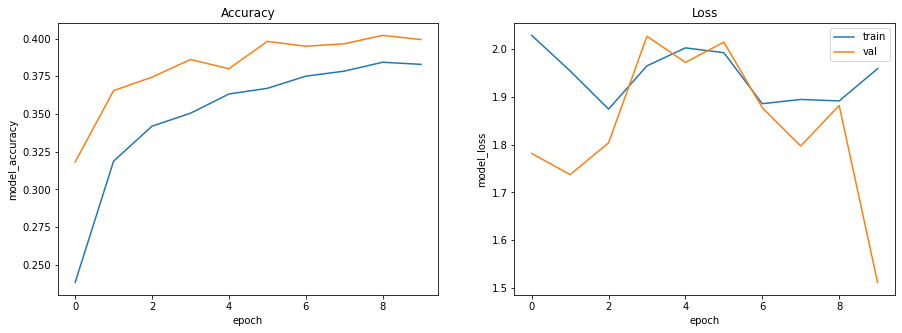

In [18]:
### Plotting accuracy/loss graph
def get_loss(history_loss):
    loss = []
    for epoch in history_loss:
        loss.append(epoch[-1])
    return loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = get_loss(history.history['loss'])
val_loss = get_loss(history.history['val_loss'])
print('train_acc:', round(acc[-1], 3), "    ", 'train_loss:', round(loss[-1], 3))
print('val_acc:', round(val_acc[-1], 3), "      ", 'val_loss:', round(val_loss[-1], 3))
fig = plt.figure(figsize=(15, 5))
## Accuracy plot
plt.subplot(1, 2, 1) 
plt.plot(acc)
plt.plot(val_acc)
plt.title('Accuracy')
plt.ylabel('model_accuracy')
plt.xlabel('epoch')
## Loss plot
plt.subplot(1, 2, 2) 
plt.plot(loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('model_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()